# **Sentiment Analysis**
- In this notebook we carry out a sentiment analysis on reviews data from Amazon and Yelp.
- In this notebook will apply technics learn in the notebook NLP-Intro on a large dataset.
- We will also build a model using tensor flow on this data.

## **Libraries**
- Now will import libraries and dependances used in this notebook.
- We will user tensorflow and its preprocessing function for text data.
- Will also use pandas and numpy in preprocessing the data.

In [ ]:
import io
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences =  tf.keras.preprocessing.sequence.pad_sequences
keras = tf.keras
Sequential = tf.keras.Sequential

## **Import Data**
- The data will be using in this notebook was pulled from kaggle, cleaned and saved on google drive.
- We will now download the data used in this notebook which is saved on google drive.

In [ ]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2022-07-20 05:35:01--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.100, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/le6brpcmsu0ifbekj9bvb96jeee2p3ur/1658295300000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=a6d44157-a19d-41d2-8a66-940bb231c7bf [following]
--2022-07-20 05:35:01--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/le6brpcmsu0ifbekj9bvb96jeee2p3ur/1658295300000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=a6d44157-a19d-41d2-8a66-940bb231c7bf
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-08

In [ ]:
dataset = pd.read_csv('/tmp/sentiment.csv')
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


## **Preprocessing**
- Now will preprocess our data.
- Firstly will convert the different column in dataset into lists.

In [ ]:
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

__Comments__
- Now will split both the sentences and labels into training and testing datasets.
- We make 80% of the data our trainning set and 20% testing set.
- We will also convert our train and testing list into numpy array for tensorflow.

In [ ]:
training_size = int(len(sentences)*0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_labels_np = np.array(training_labels)
testing_labels_np = np.array(testing_labels)

### **Tokenization**
- Now will tokenize our sentences.
- Here are some of the parameters will be using
  1. We will create a dictionary with 1000 most common words from our sentences.
  2. Maximum length of our sequences will be 100
  3. We will use post padding for sequences less than 100 and post truncating for sequence with words greater than 100.
  4. We will add out of vocabulary( OOV) to our tokenizer.
  5. 

In [ ]:
vocab_size = 500
max_length = 50
padding_type = 'post'
trunc_type = 'post'
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
padded_training_sequences = pad_sequences(training_sequences, maxlen = max_length, 
                                          padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_testing_sequences = pad_sequences(testing_sequences, maxlen = max_length, 
                                          padding = padding_type, truncating = trunc_type)

__Comments__
- Now will review our preprocessing results.
- We check the value in the word index of words appearing the sentence shown.

In [ ]:
print('1st sentence: ', training_sentences[:1])
print('1st padded training sequences: ', padded_training_sequences[:1])

1st sentence:  ['So there is no way for me to plug it in here in the US unless I go by a converter.']
1st padded training sequences:  [[ 26  68   7  63 173  13  67   8 218   5  16  82  16   2 197 363   4  75
  109   6   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
for i in ['unless', 'there', 'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here']:
  print('Value in word {} index is {}'.format('', word_index[i]))

Value in word  index is 363
Value in word  index is 68
Value in word  index is 7
Value in word  index is 63
Value in word  index is 173
Value in word  index is 13
Value in word  index is 67
Value in word  index is 8
Value in word  index is 218
Value in word  index is 5
Value in word  index is 16
Value in word  index is 82


## **Sentiment Model**
- Now that we are done with preprocessing our data, we now build our model for sentiment classifications.
- For this will make use of the Embedding layer in tensorflow keras.
- This will make each unique word in our vocabular a vector in the embedding dimension.
- This will allow the model to determine the how those words appear in negative or positive sentiments.
- Now will set our embedding dimesion to 16.

In [ ]:
embedding_dim = 16

__Comments__
- Our model will have the following layers.
  1. The input layers will be the Embedding layers and the input length will match the maximum length for each sequence.
  2. Will flatten the results of the embedding layer to move it for the 16 dimension to the 2D for the following dense layers.
  3. Now will have a dense layer with 16 units and relu activation
  4. The output layer is a dense layer with 1 unit as have to output states and has sigmoid activation function for binary classification.

In [ ]:
model = Sequential([
                    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                    keras.layers.GlobalAveragePooling1D(),#keras.layers.Flatten(),
                    keras.layers.Dense(16, activation = 'relu'),
                    keras.layers.Dense(1) #, activation = 'sigmoid'
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,289
Trainable params: 8,289
Non-trainable params: 0
_________________________________________________________________


### **Model Compiling**
- For compling our model will make use of the binary cross enthropy loss function.
- We will also use the adam optimizer and accuracy as our metric to measure.

In [ ]:
model.compile(loss = keras.losses.BinaryCrossentropy(from_logits = True), 
              optimizer = 'adam', metrics = ['accuracy']) #'binary_crossentropy'

### **Training Model**
- Now will train our model using 10 epochs.

In [ ]:
EPOCHS = 30
history = model.fit(padded_training_sequences, training_labels_np, epochs = EPOCHS,
          validation_data = (padded_testing_sequences, testing_labels_np))

Epoch 1/30
50/50 [==============================] - 1s 7ms/step - loss: 0.6925 - accuracy: 0.4777 - val_loss: 0.6962 - val_accuracy: 0.5890
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.4777 - val_loss: 0.6952 - val_accuracy: 0.5890
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.4777 - val_loss: 0.6927 - val_accuracy: 0.5890
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.4777 - val_loss: 0.6859 - val_accuracy: 0.5890
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.4777 - val_loss: 0.6804 - val_accuracy: 0.5890
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.4777 - val_loss: 0.6510 - val_accuracy: 0.5890
Epoch 7/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6253 - accuracy: 0.5085 - val_loss: 0.6395 - val_accuracy: 0.6441
Epoch 8/30
50/50 [==

### Training Results
- Now will look at the reuslt of the training process.

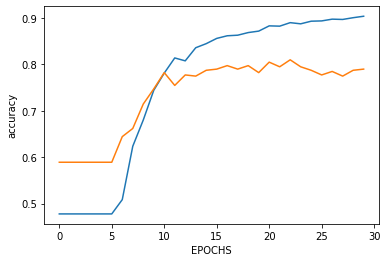

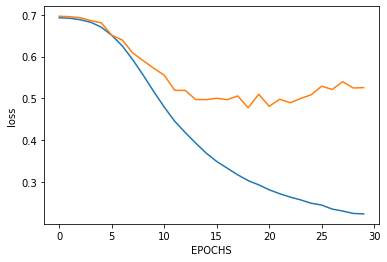

In [ ]:
def plot_results(model_history, metric):
  plt.plot(model_history.history[metric], label = metric)
  plt.plot(model_history.history['val_'+metric], label = 'val_'+metric)
  plt.xlabel('EPOCHS')
  plt.ylabel(metric)
  plt.show()

plot_results(history, 'accuracy')
plot_results(history, 'loss')

### Visualising Network
- Now will visualize the embedding and see each word relative to the sentiment.

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(500, 16)


In [ ]:
reverse_word_index = {}
for key, value in word_index.items():
  reverse_word_index[value] = key

In [ ]:
out_v = io.open('vecs.tsv', 'w', encoding = 'utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join([ str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Conclusion**
- This is the was our model demostration how we can create a sentiment analysis on reviews data.
- We utilise preprocessing technics we for word processing.